In [1]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '2' 
from autocvd import autocvd
autocvd(num_gpus = 1)

import jax 
import jax.numpy as jnp
from jax import jit, random
import equinox as eqx
from jax.sharding import Mesh, PartitionSpec, NamedSharding

# jax.config.update("jax_enable_x64", True)
import matplotlib.pyplot as plt

from functools import partial

import numpy as np
from astropy import units as u
from astropy import constants as c

import odisseo
from odisseo import construct_initial_state
from odisseo.integrators import leapfrog
from odisseo.dynamics import direct_acc, DIRECT_ACC, DIRECT_ACC_LAXMAP, DIRECT_ACC_FOR_LOOP, DIRECT_ACC_MATRIX, NO_SELF_GRAVITY
from odisseo.option_classes import SimulationConfig, SimulationParams, MNParams, NFWParams, PlummerParams, PSPParams, MN_POTENTIAL, NFW_POTENTIAL, PSP_POTENTIAL, DIFFRAX_BACKEND, LEAPFROG
from odisseo.option_classes import SEMIIMPLICITEULER, TSIT5
from odisseo.option_classes import RECURSIVECHECKPOINTADJOING, FORWARDMODE
from odisseo.initial_condition import Plummer_sphere, Plummer_sphere_reparam
from odisseo.utils import center_of_mass
from odisseo.time_integration import time_integration
from odisseo.units import CodeUnits
from odisseo.visualization import create_3d_gif, create_projection_gif, energy_angular_momentum_plot
from odisseo.potentials import MyamotoNagai, NFW

from odisseo.utils import halo_to_gd1_velocity_vmap, halo_to_gd1_vmap, projection_on_GD1
from jax.test_util import check_grads

plt.rcParams.update({
    'font.size': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'legend.fontsize': 15,
})

plt.style.use('default')

import interpax

In [8]:
code_length = 10 * u.kpc
code_mass = 1e4 * u.Msun
G = 1
code_time = 3 * u.Gyr
code_units = CodeUnits(code_length, code_mass, G=1, unit_time = code_time )  


config = SimulationConfig(N_particles = 1000, 
                          return_snapshots = True, 
                          num_snapshots = 1000, 
                          num_timesteps = 1000, 
                          external_accelerations=(NFW_POTENTIAL, MN_POTENTIAL, PSP_POTENTIAL), 
                          acceleration_scheme = DIRECT_ACC_MATRIX,
                          softening = (0.1 * u.pc).to(code_units.code_length).value,
                          integrator = DIFFRAX_BACKEND,
                          differentation_mode=TSIT5,
                          fixed_timestep=False,
                          ) #default values

params = SimulationParams(t_end = (3 * u.Gyr).to(code_units.code_time).value,  
                          Plummer_params= PlummerParams(Mtot=(10**4.5 * u.Msun).to(code_units.code_mass).value,
                                                        a=(8 * u.pc).to(code_units.code_length).value),
                           MN_params= MNParams(M = (68_193_902_782.346756 * u.Msun).to(code_units.code_mass).value,
                                              a = (3.0 * u.kpc).to(code_units.code_length).value,
                                              b = (0.280 * u.kpc).to(code_units.code_length).value),
                          NFW_params= NFWParams(Mvir=(4.3683325e11 * u.Msun).to(code_units.code_mass).value,
                                               r_s= (16.0 * u.kpc).to(code_units.code_length).value,),      
                          PSP_params= PSPParams(M = 4501365375.06545 * u.Msun.to(code_units.code_mass),
                                                alpha = 1.8, 
                                                r_c = (1.9*u.kpc).to(code_units.code_length).value),                    
                          G=code_units.G, ) 


key = random.PRNGKey(1)

#set up the particles in the initial state
positions, velocities, mass = Plummer_sphere(key=key, params=params, config=config)

#the center of mass needs to be integrated backwards in time first 
config_com = config._replace(N_particles=1,)
params_com = params._replace(t_end=-params.t_end,)

#this is the final position of the cluster, we need to integrate backwards in time 
pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)


mass_com = jnp.array([params_com.Plummer_params.Mtot])
final_state_com = construct_initial_state(pos_com_final, vel_com_final)

snapshots_com = time_integration(final_state_com, mass_com, config_com, params_com)
pos_com, vel_com = snapshots_com.states[-1, :, 0], snapshots_com.states[-1, :, 1]


# Add the center of mass position and velocity to the Plummer sphere particles
positions = positions + pos_com
velocities = velocities + vel_com

#initialize the initial state
initial_state_stream = construct_initial_state(positions, velocities)

#run the simulation
snapshots = time_integration(initial_state_stream, mass, config, params)

final_state = snapshots.states[-1]
stream_data = projection_on_GD1(final_state, code_units=code_units,)
print("Simulated GD1")


# LET'S TRY OPTIMIZING IT

params_sim = params
config_com = config_com._replace(diffrax_adjoint_method=FORWARDMODE,
)


# phi1_min, phi1_max = -100, 25
# phi2_min, phi2_max = -8, 2


stream_data = stream_data[(stream_data[:, 1] > -95) & (stream_data[:, 1] < 20)]  # Filter data within phi1 range
@partial(jit, static_argnames=['return_residual'])
def run_simulation( y, return_residual=True):

    Mvir, M_MN, r_s, a, b, = y
    Mvir = 10**Mvir
    M_MN = 10**M_MN
    r_s = 10**r_s
    a = 10**a
    b = 10**b

    phi1_min, phi1_max = -100, 25
    phi2_min, phi2_max = -8, 2

    coord_indices = jnp.array([2, 3, 4, 5])


    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)

    #function that integrates the com backwards and forwards in time and then the stream, and projects it on the sky
    @jit
    def assign_params_integrate_projection(t_end):
        

        new_params = params_sim._replace(
                    NFW_params=params_sim.NFW_params._replace(
                        Mvir=Mvir * u.Msun.to(code_units.code_mass), 
                        r_s=r_s * u.kpc.to(code_units.code_length)
                    ),
                    MN_params=params_sim.MN_params._replace(
                        M=M_MN * u.Msun.to(code_units.code_mass),
                        a=a * u.kpc.to(code_units.code_length),
                        b=b * u.kpc.to(code_units.code_length),
                    ),
                     t_end = t_end,)
        snapshots = time_integration(initial_state_com, mass, config=config_com, params=new_params)
        stream_coordinate = jax.vmap(projection_on_GD1, in_axes=(0, None))(snapshots.states, code_units)
        return stream_coordinate

    t_end_mag = 0.5 * u.Gyr.to(code_units.code_time)
    t_end_array = jnp.array([-t_end_mag, t_end_mag])  # backward, forward
    

    # vmap over both parameters
    stream_coordinate_com = jax.vmap(assign_params_integrate_projection)(t_end_array)
    stream_coordinate_com_backward, stream_coordinate_com_forward = stream_coordinate_com[0], stream_coordinate_com[1]


    # Create masks for valid time steps
    mask_window_backward = (stream_coordinate_com_backward[:, 0, 1] < phi1_max) & \
                          (stream_coordinate_com_backward[:, 0, 1] > phi1_min) & \
                          (stream_coordinate_com_backward[:, 0, 2] < phi2_max) & \
                          (stream_coordinate_com_backward[:, 0, 2] > phi2_min)
    
    mask_diff_backward = jnp.ediff1d(stream_coordinate_com_backward[:, 0, 1], to_begin=1) > 0
    # New mask - True until first False appears
    mask_diff_backward = jnp.cumprod(mask_diff_backward, dtype=bool)


    mask_window_forward = (stream_coordinate_com_forward[:, 0, 1] < phi1_max) & \
                         (stream_coordinate_com_forward[:, 0, 1] > phi1_min) & \
                         (stream_coordinate_com_forward[:, 0, 2] < phi2_max) & \
                         (stream_coordinate_com_forward[:, 0, 2] > phi2_min)
    
    mask_diff_forward = jnp.ediff1d(stream_coordinate_com_forward[:, 0, 1], to_begin=-1) < 0
    mask_diff_forward = jnp.cumprod(mask_diff_forward, dtype=bool)

    mask_backward = mask_window_backward & mask_diff_backward
    mask_forward = mask_window_forward & mask_diff_forward


    # return {'stream_coordinate_com_backward': stream_coordinate_com_backward,
    #         'stream_coordinate_com_forward': stream_coordinate_com_forward,
    #         'mask_backward': mask_backward,
    #         'mask_forward': mask_forward,
    #         'phi1_backward_valid': phi1_backward_valid,
    #         'phi1_forward_valid': phi1_forward_valid
    # }

    def coord_backward_fill(arr_phi1, arr_coord, mask):
        arr_phi1_masked = jnp.where(mask, arr_phi1, 0.0)
        filled = jnp.where(arr_phi1_masked == 0., jnp.max(arr_phi1_masked), arr_phi1_masked)
        arr_coord_masked = jnp.where(mask, arr_coord, 0.0)
        filled_coord = jnp.where(arr_coord_masked == 0., arr_coord_masked[jnp.argmax(filled)], arr_coord_masked)
        return filled, filled_coord

    def coord_forward_fill(arr_phi1, arr_coord, mask):
        arr_phi1_masked = jnp.where(mask, arr_phi1, 0.0)
        filled = jnp.where(arr_phi1_masked == 0., jnp.min(arr_phi1_masked), arr_phi1_masked)
        arr_coord_masked = jnp.where(mask, arr_coord, 0.0)
        filled_coord = jnp.where(arr_coord_masked == 0., arr_coord_masked[jnp.argmin(filled)], arr_coord_masked)
        return filled, filled_coord

    phi1_backward_valid, coord_backward_valid = jax.vmap(lambda coordinate: coord_backward_fill(stream_coordinate_com_backward[:, 0, 1], stream_coordinate_com_backward[:, 0, coordinate], mask_backward))(coordinate=coord_indices)
    phi1_forward_valid, coord_forw_valid = jax.vmap(lambda coordinate: coord_forward_fill(stream_coordinate_com_forward[:, 0, 1], stream_coordinate_com_forward[:, 0, coordinate], mask_forward))(coordinate=coord_indices)


    def interpolate_coord_backward(coord):
        # Interpolator = interpax.Interpolator1D(
        #     x=phi1_backward_valid[0],
        #     f=coord,
        #     method='cubic',
        # )
        # return Interpolator(stream_data[:, 1])  # Interpolate at data phi1 values
        return jnp.interp(stream_data[:, 1], phi1_backward_valid[0], coord)
    
    def interpolate_coord_forward(coord):
        # Interpolator = interpax.Interpolator1D(
        #     x=phi1_forward_valid[0],
        #     f=coord,
        #     method='cubic',
        # )
        # return Interpolator(stream_data[:, 1])  # Interpolate at data phi1 values
        return jnp.interp(stream_data[:, 1], phi1_forward_valid[0][::-1], coord[::-1])
        

    # Apply interpolation to all coordinates
    interp_tracks_backward = jax.vmap(interpolate_coord_backward)(coord_backward_valid)  # Shape: (n_coords, n_data)
    interp_tracks_forward = jax.vmap(interpolate_coord_forward)(coord_forw_valid)  # Shape: (n_coords, n_data)

    # return {'stream_coordinate_com_backward': stream_coordinate_com_backward,
    #         'stream_coordinate_com_forward': stream_coordinate_com_forward,
    #         'mask_backward': mask_backward,
    #         'mask_forward': mask_forward,
    #         'phi1_backward_valid': phi1_backward_valid,
    #         'phi1_forward_valid': phi1_forward_valid,
    #         'coord_backward_valid': coord_backward_valid,
    #         'coord_forw_valid': coord_forw_valid,
    #         'interp_tracks_backward': interp_tracks_backward,
    #         'interp_tracks_forward': interp_tracks_forward,
    # }

    # Calculate residuals for all coordinates
    data_coords = stream_data[:, coord_indices].T  # Shape: (n_coords, n_data)
    sigma = jnp.array([0.5, 10., 2., 2. ])
    # sigma = jnp.array([0.15, 5., 0.1, 0.0001]) #from albatross

    mask_correct_interpolation_backward = stream_data[:, 1] < 20
    mask_correct_interpolation_forward = stream_data[:, 1] > - 95

    # Stream data masks - which data points to use for each direction
    mask_stream_backward = stream_data[:, 1] > stream_coordinate_com_backward[0, 0, 1]
    mask_stream_forward = stream_data[:, 1] < stream_coordinate_com_forward[0, 0, 1]

    mask_evaluate_inside_track_backward = (stream_data[:, 1] < jnp.max(phi1_backward_valid)) & (stream_data[:, 1] < phi1_max)
    mask_evaluate_inside_track_forward = (stream_data[:, 1] > jnp.min(phi1_forward_valid)) & (stream_data[:, 1] > phi1_min)

    # Calculate chi2 using only the appropriate data points for each direction
    residuals_backward = jnp.where(mask_stream_backward & mask_evaluate_inside_track_backward & mask_correct_interpolation_backward, 
                                  (data_coords - interp_tracks_backward)/sigma[:, None],
                                   1.)
    residuals_forward = jnp.where(mask_stream_forward & mask_evaluate_inside_track_forward & mask_correct_interpolation_forward, 
                                 (data_coords - interp_tracks_forward)/sigma[:, None],
                                  1.)
    residuals = jnp.where(mask_stream_backward,
                         residuals_backward,
                         residuals_forward)
    # Masks for valid residuals
    mask_backward_full = mask_stream_backward & mask_evaluate_inside_track_backward & mask_correct_interpolation_backward
    mask_forward_full = mask_stream_forward & mask_evaluate_inside_track_forward & mask_correct_interpolation_forward
    
    n_eff_backward = jnp.nansum(mask_backward_full) * 4
    n_eff_forward = jnp.nansum(mask_forward_full) * 4
    n_total = n_eff_backward + n_eff_forward
    
    # Chi-squared
    # chi2 = jnp.sum(residuals_backward**2) + jnp.sum(residuals_forward**2)
    chi2 = jnp.sum(residuals**2)
    
    
    if return_residual:
        # Return residuals divided by sqrt(dof) for proper scaling
        # all_residuals = jnp.concatenate([residuals_backward, residuals_forward], axis=1).flatten()
        # return all_residuals 
        return residuals
    else:
        return chi2 

print("beginning least square optimization")

from optimistix import least_squares
import optimistix


# Shape will be (4, 4)
def sample_initial_conditions(key, n_samples, params, code_units):
    """
    Sample initial conditions from a uniform prior.
    
    Parameters are sampled uniformly in log-space between 0.5x and 2x the true values.
    
    Args:
        key: JAX random key
        n_samples: Number of samples to generate
        params: SimulationParams object with true parameter values
        code_units: CodeUnits object for unit conversions
    
    Returns:
        Array of shape (n_samples, 5) with log10 of [Mvir, M_MN, r_s, a, b]
    """
    # Get true values in physical units
    true_Mvir = params.NFW_params.Mvir * code_units.code_mass.to(u.Msun)
    true_M_MN = params.MN_params.M * code_units.code_mass.to(u.Msun)
    true_r_s = params.NFW_params.r_s * code_units.code_length.to(u.kpc)
    true_a = params.MN_params.a * code_units.code_length.to(u.kpc)
    true_b = params.MN_params.b * code_units.code_length.to(u.kpc)
    
    # Define bounds: [0.5 * true_value, 2.0 * true_value]
    min_factor = 0.5
    max_factor = 2.0
    
    # Stack true values
    true_values = jnp.array([true_Mvir, true_M_MN, true_r_s, true_a, true_b])
    
    # Calculate min and max in log space
    log_min = jnp.log10(true_values * min_factor)
    log_max = jnp.log10(true_values * max_factor)
    
    # min_vals = true_values * min_factor
    # max_vals = true_values * max_factor
    # Sample uniformly in log space
    keys = random.split(key, 5)
    samples = []
    
    for i in range(5):
        param_samples = random.uniform(
            keys[i], 
            shape=(n_samples,), 
            minval=log_min[i], 
            maxval=log_max[i]
        )
        samples.append(param_samples)
    
    # Stack into (n_samples, 5) array
    y0_batched = jnp.stack(samples, axis=1)
    
    return y0_batched


# Example usage:
key = random.PRNGKey(0)
n_samples = 1
initial_condition = sample_initial_conditions(key, n_samples, params, code_units)

output = run_simulation(initial_condition[0], return_residual=False)

Simulated GD1
beginning least square optimization


In [9]:
output

Array(2008.629, dtype=float32)

In [59]:
output.keys()

AttributeError: 'jaxlib._jax.ArrayImpl' object has no attribute 'keys'

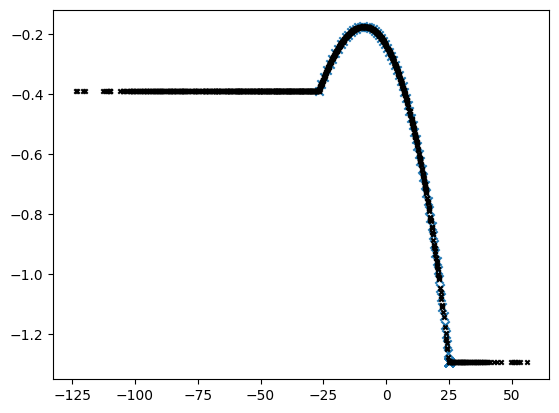

In [56]:
mask_backward = output['mask_backward']
mask_forward = output['mask_forward']
phi1_backward_valid = output['phi1_backward_valid']
phi1_forward_valid = output['phi1_forward_valid']
coord_backward_valid = output['coord_backward_valid']
interp_tracks_backward = output['interp_tracks_backward']
# plt.scatter(output['stream_coordinate_com_backward'][:, 0, 1], output['stream_coordinate_com_backward'][:, 0, 2], s=1)
plt.scatter(phi1_backward_valid[0], coord_backward_valid[0], marker='x')
plt.scatter(stream_data[:, 1], interp_tracks_backward[0], s=10, color='black', marker='x')


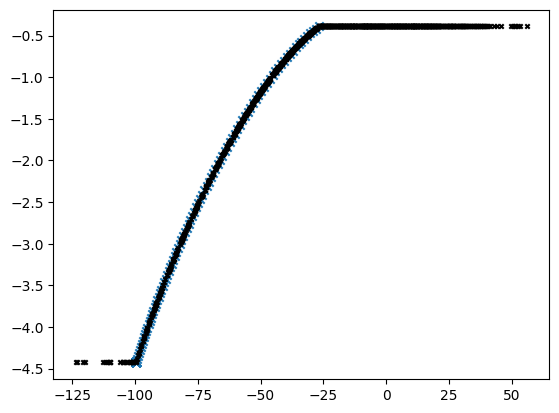

In [57]:
mask_forward = output['mask_forward']
phi1_forward_valid = output['phi1_forward_valid']
coord_forw_valid = output['coord_forw_valid']
interp_tracks_forward = output['interp_tracks_forward']
plt.scatter(phi1_forward_valid[0], coord_forw_valid[0], marker='x')
plt.scatter(stream_data[:, 1], interp_tracks_forward[0], s=10, color='black', marker='x')

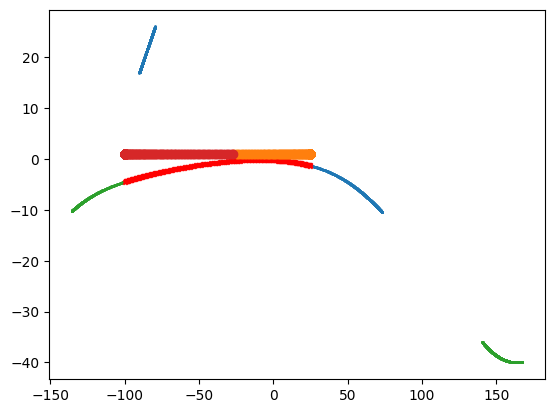

In [67]:
mask_backward = output['mask_backward']
mask_forward = output['mask_forward']
phi1_backward_valid = output['phi1_backward_valid']
phi1_forward_valid = output['phi1_forward_valid']
plt.scatter(output['stream_coordinate_com_backward'][:, 0, 1], output['stream_coordinate_com_backward'][:, 0, 2], s=1)
plt.scatter(output['stream_coordinate_com_backward'][:, 0, 1][mask_backward], output['stream_coordinate_com_backward'][:, 0, 2][mask_backward], s=10, color='r', marker='x')
plt.scatter(phi1_backward_valid, jnp.zeros_like(phi1_backward_valid)+1)
plt.scatter(output['stream_coordinate_com_forward'][:, 0, 1], output['stream_coordinate_com_forward'][:, 0, 2], s=1)
plt.scatter(output['stream_coordinate_com_forward'][:, 0, 1][mask_forward], output['stream_coordinate_com_forward'][:, 0, 2][mask_forward], s=10, color='r', marker='x')
plt.scatter(phi1_forward_valid, jnp.zeros_like(phi1_forward_valid)+1)

In [56]:

def backward_fill(arr, mask):
        """Forward-fill masked array: replace invalid entries with the last valid value."""
        arr_masked = jnp.where(mask, arr, 0.0)
        filled = jnp.where(arr_masked == 0., jnp.max(arr_masked), arr_masked)
        return filled

arr = output['stream_coordinate_com_backward'][:, 0, 1]
mask = output['mask_backward']
filled_arr = backward_fill(arr, mask)
filled_arr  

Array([-26.889313  , -25.76702   , -24.651783  , -23.544191  ,
       -22.444826  , -21.354244  , -20.272926  , -19.201372  ,
       -18.140034  , -17.089308  , -16.04958   , -15.021198  ,
       -14.004485  , -12.999712  , -12.007126  , -11.02696   ,
       -10.059406  ,  -9.104598  ,  -8.162681  ,  -7.233757  ,
        -6.3179154 ,  -5.4151845 ,  -4.525628  ,  -3.649233  ,
        -2.7859845 ,  -1.935881  ,  -1.0988319 ,  -0.27479807,
         0.5363043 ,   1.33457   ,   2.1201203 ,   2.8930483 ,
         3.6534994 ,   4.4016027 ,   5.137509  ,   5.8613744 ,
         6.573355  ,   7.2736197 ,   7.962342  ,   8.63969   ,
         9.305842  ,   9.960996  ,  10.605306  ,  11.2389765 ,
        11.862178  ,  12.475116  ,  13.077962  ,  13.670905  ,
        14.25414   ,  14.827839  ,  15.392185  ,  15.947373  ,
        16.493576  ,  17.030962  ,  17.559723  ,  18.080025  ,
        18.592043  ,  19.095932  ,  19.591883  ,  20.080053  ,
        20.560581  ,  21.03365   ,  21.499405  ,  21.95

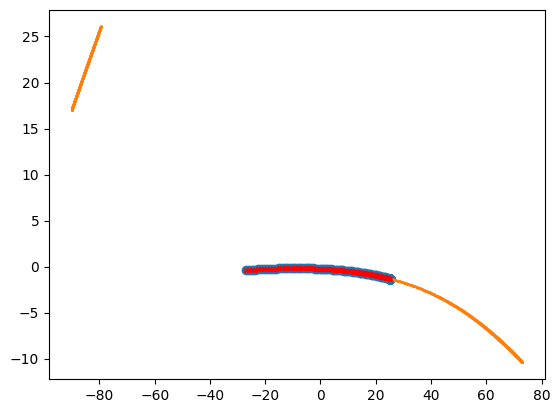

In [75]:
@jit
def coord_backward_fill(arr_phi1, arr_coord, mask):
        arr_phi1_masked = jnp.where(mask, arr_phi1, 0.0)
        filled = jnp.where(arr_phi1_masked == 0., jnp.max(arr_phi1_masked), arr_phi1_masked)
        arr_coord_masked = jnp.where(mask, arr_coord, 0.0)
        filled_coord = jnp.where(arr_coord_masked == 0., arr_coord_masked[jnp.argmax(filled)], arr_coord_masked)
        return filled, filled_coord

arr_phi1 = output['stream_coordinate_com_backward'][:, 0, 1]
arr_coord = output['stream_coordinate_com_backward'][:, 0, 2]
mask = output['mask_backward']
filled_arr, filled_coord = coord_backward_fill(arr_phi1, arr_coord, mask)
plt.scatter(filled_arr, filled_coord)
plt.scatter(output['stream_coordinate_com_backward'][:, 0, 1], output['stream_coordinate_com_backward'][:, 0, 2], s=1)
plt.scatter(output['stream_coordinate_com_backward'][:, 0, 1][mask_backward], output['stream_coordinate_com_backward'][:, 0, 2][mask_backward], s=10, color='r', marker='x')

In [23]:
@jit
def coord_backward_fill(arr_phi1, arr_coord, mask):
        arr_phi1_masked = jnp.where(mask, arr_phi1, 0.0)
        filled = jnp.where(arr_phi1_masked == 0., jnp.max(arr_phi1_masked), arr_phi1_masked)
        arr_coord_masked = jnp.where(mask, arr_coord, 0.0)
        filled_coord = jnp.where(arr_coord_masked == 0., arr_coord_masked[jnp.argmax(filled)], arr_coord_masked)
        return filled, filled_coord
coordinates = jnp.array([2, 3, 4, 5])
arr_phi1 = output['stream_coordinate_com_backward'][:, 0, 1]
arr_coord = output['stream_coordinate_com_backward'][:, 0, 2]
mask = output['mask_backward']
filled_arr, filled_coord = jax.vmap(lambda coord: coord_backward_fill(arr_phi1, output['stream_coordinate_com_backward'][:, 0, coord], mask))(coordinates)
# plt.scatter(filled_arr, filled_coord)
# plt.scatter(output['stream_coordinate_com_backward'][:, 0, 1], output['stream_coordinate_com_backward'][:, 0, 2], s=1)
# plt.scatter(output['stream_coordinate_com_backward'][:, 0, 1][mask_backward], output['stream_coordinate_com_backward'][:, 0, 2][mask_backward], s=10, color='r', marker='x')

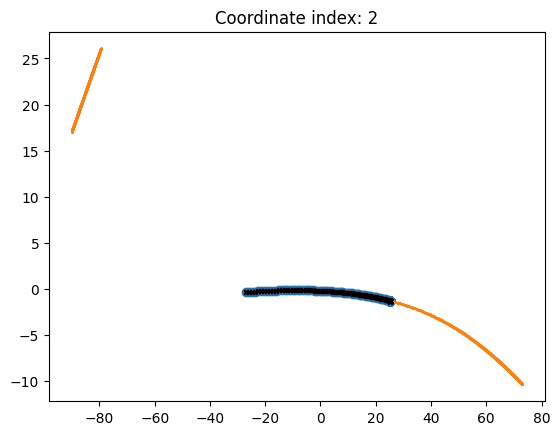

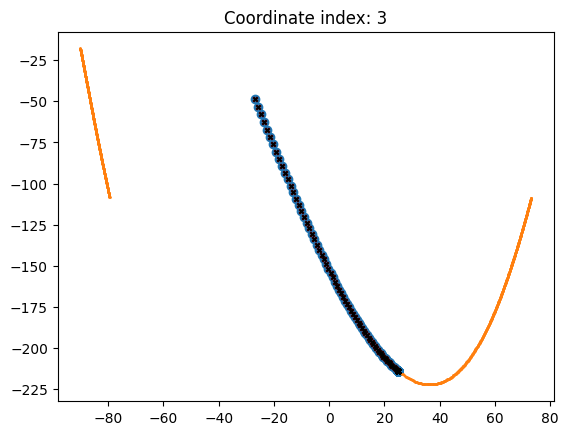

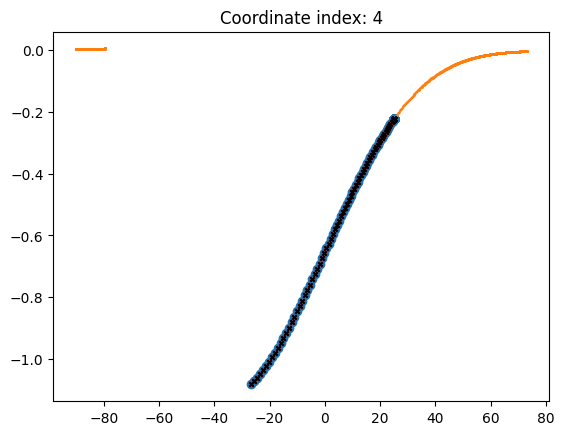

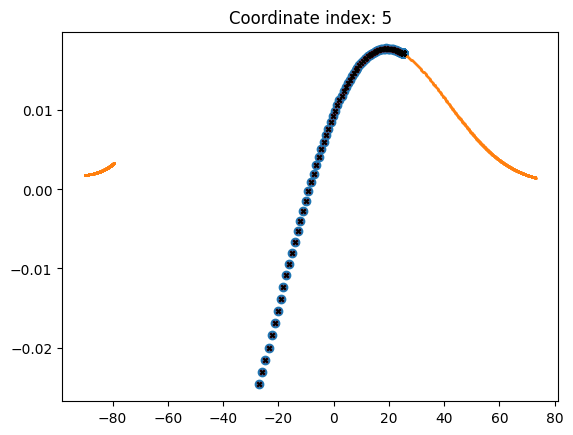

In [25]:
for i in range(len(coordinates)):
    plt.figure()
    plt.title(f"Coordinate index: {coordinates[i]}")
    plt.scatter(filled_arr[i], filled_coord[i])
    plt.scatter(output['stream_coordinate_com_backward'][:, 0, 1], output['stream_coordinate_com_backward'][:, 0, coordinates[i]], s=1)
    plt.scatter(output['stream_coordinate_com_backward'][:, 0, 1][mask_backward], output['stream_coordinate_com_backward'][:, 0, coordinates[i]][mask_backward], s=10, color='r', marker='x')
    plt.scatter(filled_arr[i], filled_coord[i], s=10, color='black', marker='x')

In [60]:
def forward_fill(arr, mask):
        """Forward-fill masked array: replace invalid entries with the last valid value."""
        arr_masked = jnp.where(mask, arr, 0.0)
        filled = jnp.where(arr_masked == 0., jnp.min(arr_masked), arr_masked)
        return filled

arr = output['stream_coordinate_com_forward'][:, 0, 1]
mask = output['mask_forward']
filled_arr = forward_fill(arr, mask)
filled_arr  

Array([-26.889313, -28.018036, -29.152504, -30.292078, -31.436035,
       -32.583675, -33.73425 , -34.88703 , -36.041275, -37.196198,
       -38.351036, -39.505054, -40.657463, -41.80752 , -42.954468,
       -44.097614, -45.236183, -46.369526, -47.496933, -48.617764,
       -49.7314  , -50.8372  , -51.934628, -53.0231  , -54.10215 ,
       -55.17125 , -56.229992, -57.27793 , -58.31471 , -59.339947,
       -60.353355, -61.35466 , -62.343582, -63.319912, -64.28347 ,
       -65.234055, -66.17161 , -67.09594 , -68.007065, -68.90488 ,
       -69.78937 , -70.660484, -71.518295, -72.362785, -73.19405 ,
       -74.01212 , -74.8171  , -75.60908 , -76.38815 , -77.154465,
       -77.90813 , -78.64929 , -79.3781  , -80.094734, -80.79932 ,
       -81.49203 , -82.17308 , -82.842606, -83.50081 , -84.14785 ,
       -84.78395 , -85.40928 , -86.02402 , -86.62836 , -87.2225  ,
       -87.806656, -88.38095 , -88.94562 , -89.50086 , -90.04682 ,
       -90.583694, -91.111694, -91.63096 , -92.141685, -92.644

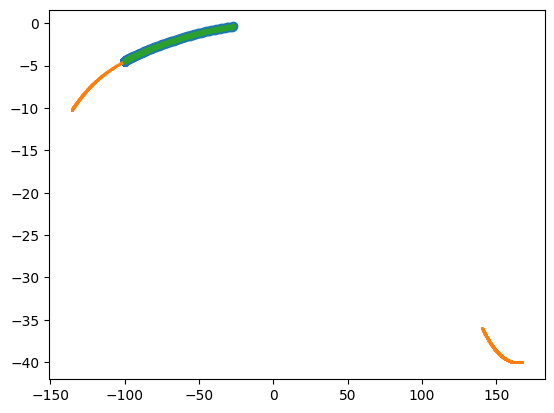

In [78]:
@jit
def coord_forward_fill(arr_phi1, arr_coord, mask):
        arr_phi1_masked = jnp.where(mask, arr_phi1, 0.0)
        filled = jnp.where(arr_phi1_masked == 0., jnp.min(arr_phi1_masked), arr_phi1_masked)
        arr_coord_masked = jnp.where(mask, arr_coord, 0.0)
        filled_coord = jnp.where(arr_coord_masked == 0., arr_coord_masked[jnp.argmin(filled)], arr_coord_masked)
        return filled, filled_coord

arr_phi1 = output['stream_coordinate_com_forward'][:, 0, 1]
arr_coord = output['stream_coordinate_com_forward'][:, 0, 2]
mask = output['mask_forward']
filled_arr, filled_coord = coord_forward_fill(arr_phi1, arr_coord, mask)
plt.scatter(filled_arr, filled_coord)
plt.scatter(output['stream_coordinate_com_forward'][:, 0, 1], output['stream_coordinate_com_forward'][:, 0, 2], s=1)
plt.scatter(output['stream_coordinate_com_forward'][:, 0, 1][mask_forward], output['stream_coordinate_com_forward'][:, 0, 2][mask_forward], s=10)


2025-10-10 17:56:04.951336: W external/xla/xla/hlo/transforms/simplifiers/hlo_rematerialization.cc:3022] Can't reduce memory use below 12.99GiB (13952469944 bytes) by rematerialization; only reduced to 33.46GiB (35922969093 bytes), down from 39.17GiB (42056333269 bytes) originally
/export/home/vgiusepp/miniconda3/envs/odisseo_sim/lib/python3.12/site-packages/chainconsumer/chain.py:313: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = rng.multivariate_normal(mean, covariance, size=1000000)  # type: ignore


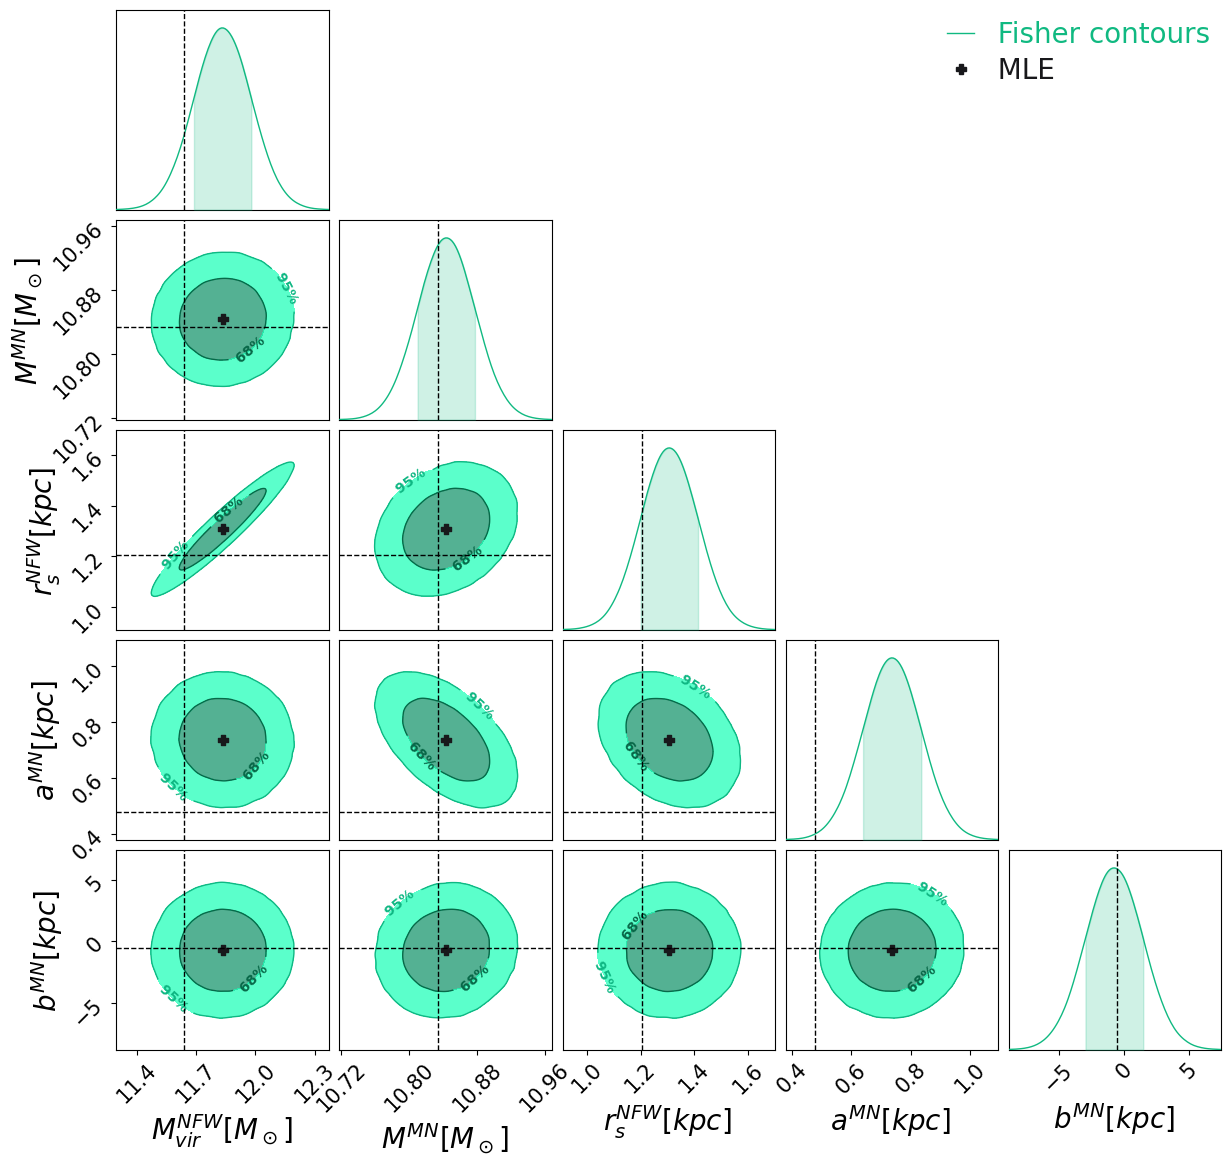

In [ ]:
n_samples = 1000
y0_batched = sample_initial_conditions(key, n_samples, params, code_units)

# Shape will be (4, 4)
def minimization_vmap(y0):
    return least_squares(
        fn=run_simulation,
        solver=optimistix.LevenbergMarquardt(rtol=1e-10, atol=1e-10),
        y0=y0,
    ).value

values = jax.vmap(minimization_vmap)(y0_batched)

likelihood = jax.vmap(lambda v: run_simulation(v, return_residual=False))(values)
MLE_index = jnp.argmin(likelihood)


#remember to put FORWARD MODE for the adjoint method when calculating the hessian
config_com = config_com._replace(diffrax_adjoint_method=FORWARDMODE,)
# hessians = jax.vmap(lambda v: jax.jacfwd(jax.jacfwd(run_simulation))(v, False))(values)
hessians = jax.jacfwd(jax.jacfwd(run_simulation))(values[MLE_index], False)

#The Fisher information matrix is the negative of the Hessian of the log-likelihood
fisher_info = hessians

#The covariance matrix is the inverse of the Fisher information matrix
covariance = 2*jnp.linalg.inv(fisher_info)


from chainconsumer import Chain, ChainConsumer, Truth, PlotConfig

colors = ['red', 'blue', 'green', 'purple']
c = ChainConsumer()
chain = Chain.from_covariance(mean=values[MLE_index], 
                                covariance=covariance, 
                                columns=["$M_{vir}^{NFW} [M_\odot]$", "$M^{MN} [M_\odot]$", "$r_s^{NFW} [kpc]$", "$a^{MN} [kpc]$", "$b^{MN} [kpc]$"], 
                                color="emerald",  
                                name=f'Fisher contours',
                                show_contour_labels=True,
                                shade_alpha=0.7
)

c.add_chain(chain)
c.add_marker(location = {"$M_{vir}^{NFW} [M_\odot]$": np.array(values[MLE_index][0]), "$M^{MN} [M_\odot]$": np.array(values[MLE_index][1]),
                            "$r_s^{NFW} [kpc]$": np.array(values[MLE_index][2]), "$a^{MN} [kpc]$": np.array(values[MLE_index][3]), "$b^{MN} [kpc]$": np.array(values[MLE_index][4]),
                            }, color="black", name='MLE', marker_style='P', marker_size=50)

c.add_truth(Truth(location = {"$M_{vir}^{NFW} [M_\odot]$": jnp.log10(params.NFW_params.Mvir * code_units.code_mass.to(u.Msun)), 
                            "$M^{MN} [M_\odot]$": jnp.log10(params.MN_params.M * code_units.code_mass.to(u.Msun)),
                            "$r_s^{NFW} [kpc]$": jnp.log10(params.NFW_params.r_s * code_units.code_length.to(u.kpc)),
                            "$a^{MN} [kpc]$": jnp.log10(params.MN_params.a * code_units.code_length.to(u.kpc)),
                            "$b^{MN} [kpc]$": jnp.log10(params.MN_params.b * code_units.code_length.to(u.kpc)),
                            }, 
                            color='black', name="True value"))


c.set_plot_config(
PlotConfig(
    max_ticks=4,
    label_font_size=20,
    tick_font_size=15,
    summary_font_size=20,

))
fig = c.plotter.plot()

In [11]:
jnp.log10(params.MN_params.a * code_units.code_length.to(u.kpc))

Array(0.47712123, dtype=float32)